Project - Age-Gender prediction

Importing Libraries

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Model
from tensorflow import keras
from keras.layers import *
from tensorflow.keras.utils import plot_model
from tqdm import tqdm 
import os


2025-03-20 02:24:52.588031: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<span style="color: white; background-color: blue; padding: 10px 15px; border-radius: 8px; font-size: 28px; font-weight: bold;">📌 Setting Dataset Path</span>

In [17]:
# Set dataset path
dataset_path = "dataset/UTKFace"

<span style="color: white; background-color: blue; padding: 10px 15px; border-radius: 8px; font-size: 28px; font-weight: bold;">📌 Extracting Labels from Filenames</span>

In [18]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(dataset_path)):
    image_path = os.path.join(dataset_path, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 213289.98it/s]


In [19]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,dataset/UTKFace/9_1_2_20161219204347420.jpg.ch...,9,1
1,dataset/UTKFace/36_0_1_20170117163203851.jpg.c...,36,0
2,dataset/UTKFace/86_1_0_20170120225751953.jpg.c...,86,1
3,dataset/UTKFace/26_1_0_20170116171048641.jpg.c...,26,1
4,dataset/UTKFace/1_1_2_20161219154612988.jpg.ch...,1,1


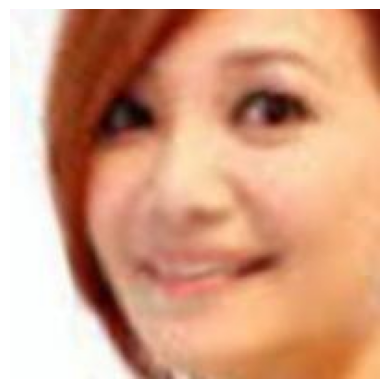

In [20]:
#example on how to open one image
from PIL import Image
img = Image.open(df['image'][20])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

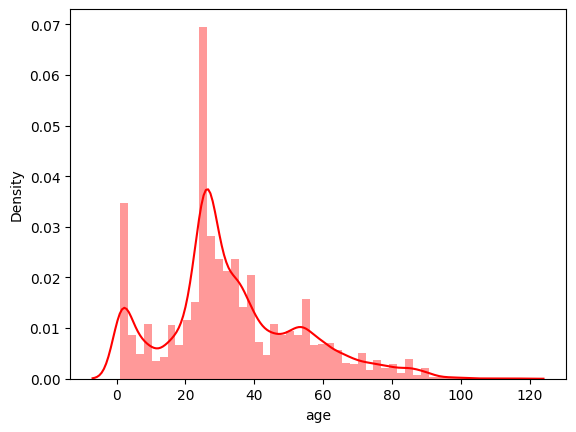

In [8]:
sns.distplot(df['age'] , color = 'red')

In [22]:
gender_dict = {0: 'Male', 1: 'Female'}

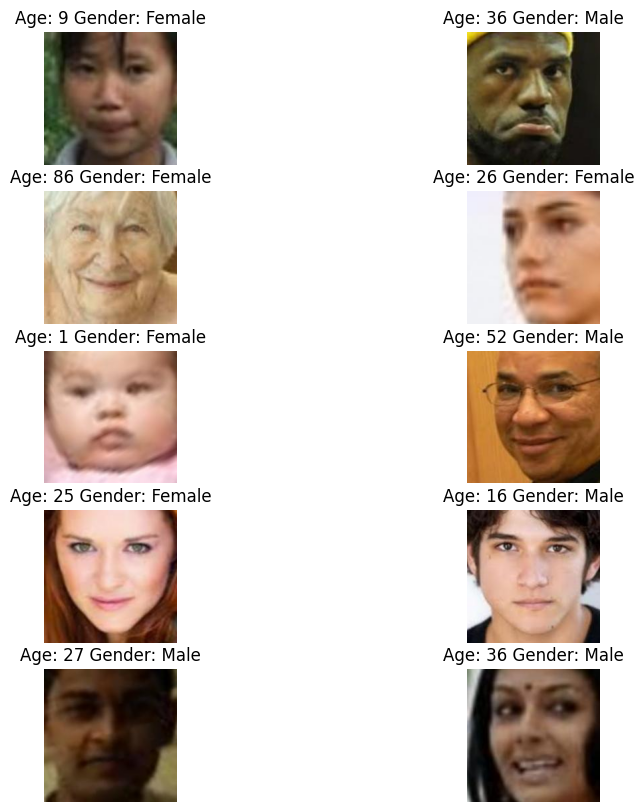

In [23]:
# to display grid of images
plt.figure(figsize=(10, 10))
files = df.iloc[:10]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 2, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

<span style="color: white; background-color: blue; padding: 10px 15px; border-radius: 8px; font-size: 28px; font-weight: bold;">📌 Extracting Image Features</span>

In [24]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS) #used for resizing images.
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [25]:
X = extract_features(df['image'])

100%|██████████| 23708/23708 [00:40<00:00, 584.64it/s]


In [26]:
X.shape


(23708, 128, 128, 1)

In [27]:
# normalize the images
X = X/255.0

In [28]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [29]:
input_shape = (128, 128, 1)


<span style="color: white; background-color: blue; padding: 10px 15px; border-radius: 8px; font-size: 28px; font-weight: bold;">📌 Building the CNN Model</span>

In [17]:
from tensorflow.keras.layers import BatchNormalization

In [6]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation=None)(inputs)
x = BatchNormalization()(conv_1)
x = ReLU()(x)
maxp1 = MaxPooling2D(pool_size=(2, 2))(x)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation=None)(maxp1)
x = BatchNormalization()(conv_2)
x = ReLU()(x)
maxp2 = MaxPooling2D(pool_size=(2, 2))(x)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation=None)(maxp2)
x = BatchNormalization()(conv_3)
x = ReLU()(x)
maxp3 = MaxPooling2D(pool_size=(2, 2))(x)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation=None)(maxp3)
x = BatchNormalization()(conv_4)
x = ReLU()(x)
maxp4 = MaxPooling2D(pool_size=(2, 2))(x)

flatten = Flatten()(maxp4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2) #Since age cannot be negative we use RELU

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 126,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 126, 126,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 63,    │          0 │ re_lu_4[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 61, 61,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 30,    │          0 │ re_lu_5[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 14, 14,    │          0 │ re_lu_6[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 6, 6, 256) │          0 │ re_lu_7[0][0]   

 Total params: 5,109,378 (19.49 MB)

 Trainable params: 5,108,418 (19.49 MB)

 Non-trainable params: 960 (3.75 KB)

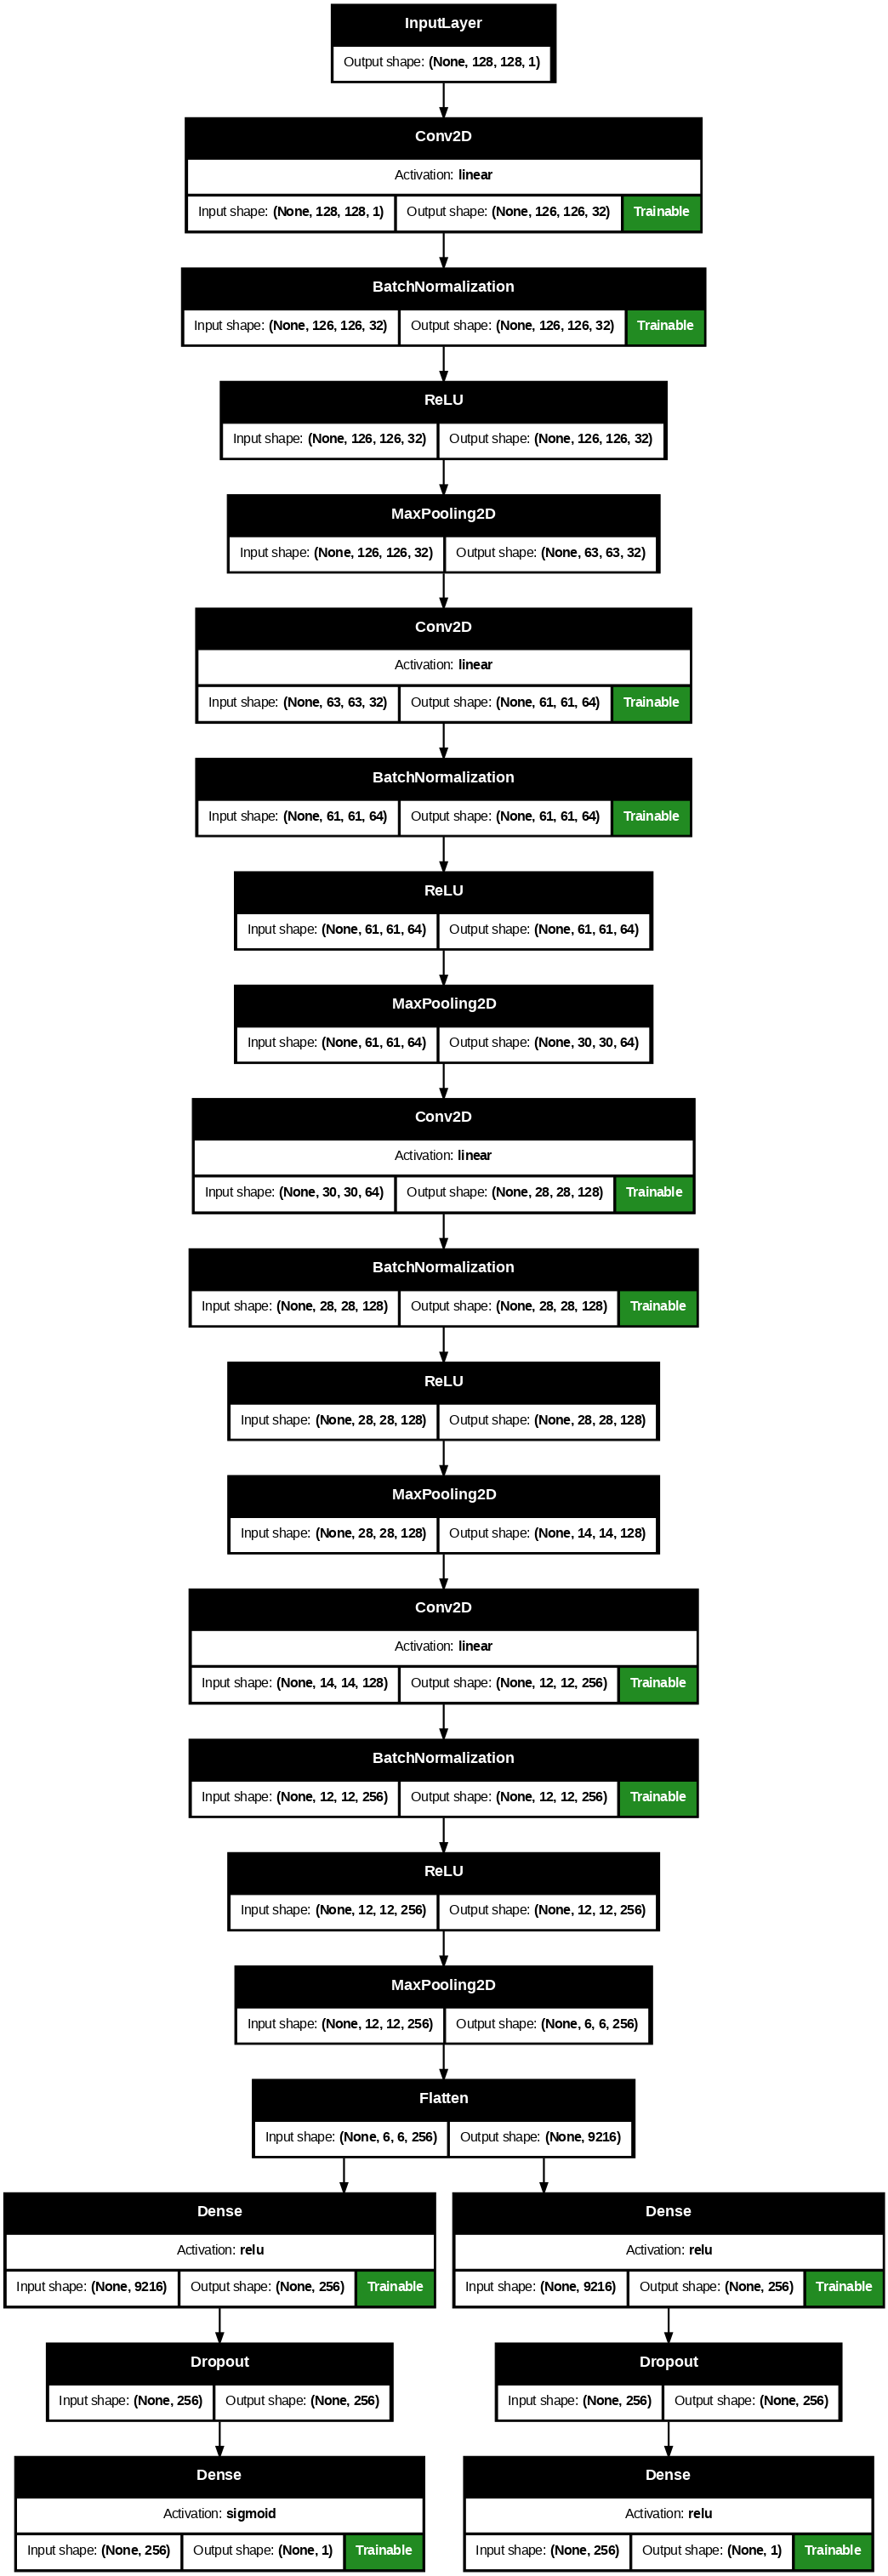

In [33]:
plot_model(
    model ,
    show_shapes = True ,
    dpi = 80,
    show_layer_activations = True,
    show_trainable = True
)

In [34]:
# Train the model with separate metrics for gender and age outputs
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)


Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - age_out_loss: 13.4073 - age_out_mae: 13.4073 - gender_out_accuracy: 0.6751 - gender_out_loss: 1.1142 - loss: 14.5215 - val_age_out_loss: 9.2787 - val_age_out_mae: 9.2890 - val_gender_out_accuracy: 0.7881 - val_gender_out_loss: 0.4498 - val_loss: 9.7380
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - age_out_loss: 9.5447 - age_out_mae: 9.5447 - gender_out_accuracy: 0.7954 - gender_out_loss: 0.4364 - loss: 9.9812 - val_age_out_loss: 8.3316 - val_age_out_mae: 8.3288 - val_gender_out_accuracy: 0.8070 - val_gender_out_loss: 0.4130 - val_loss: 8.7418
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - age_out_loss: 8.5713 - age_out_mae: 8.5713 - gender_out_accuracy: 0.8252 - gender_out_loss: 0.3710 - loss: 8.9422 - val_age_out_loss: 9.1545 - val_age_out_mae: 9.1316 - val_gender_out_accuracy: 0.8372 - val_gender_out_loss: 0.3376 - val_loss: 9.4693
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - age_out_loss: 8.0679 - 

<span style="color: white; background-color: blue; padding: 10px 15px; border-radius: 8px; font-size: 28px; font-weight: bold;">Accuracy Curve 🔴⚡</span>

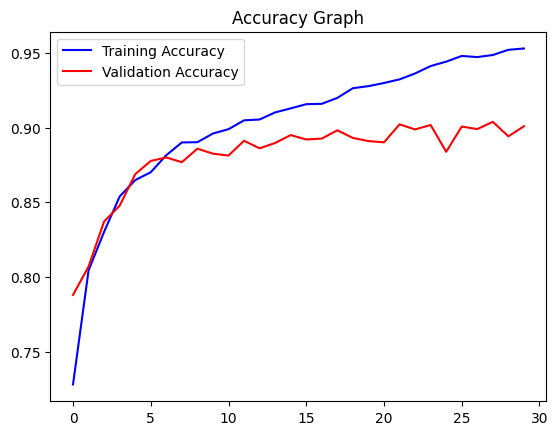

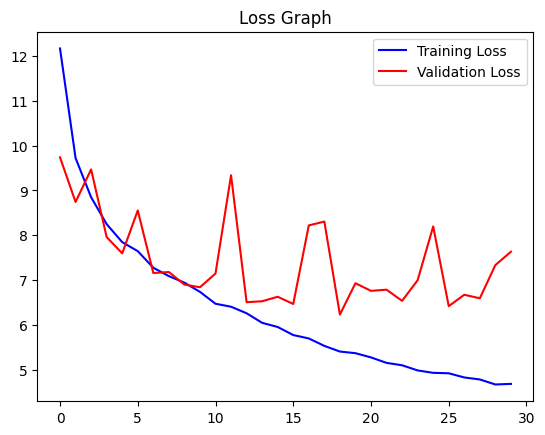

In [35]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

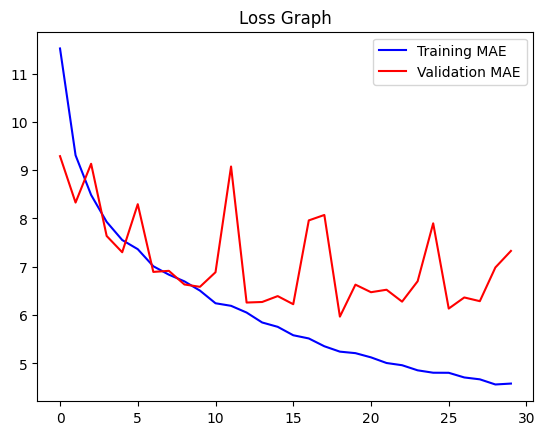

In [36]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

<span style="color: white; background-color: blue; padding: 10px 15px; border-radius: 8px; font-size: 28px; font-weight: bold;">Saving the model 💾📥</span>

In [ ]:
model.save('model.pkl')